# Explore High Exposure (HE) Landmarks

High exposure videos contain enough information to identify landmarks on the animal, rather than just the red and blue LEDs on the head. The position of the head in particular is of interest

To track these landmarks, a separate DeepLabCut model was trained specifically on high exposure videos.


## 1. Load data

Start by importing the environmental paths and loading the data


In [1]:
%matplotlib widget

import sys
from pathlib import Path

# Import local module 
sys.path.insert(0, str(Path.cwd().parent))
from loading import load_parquet

# Import local path from environmental settings
from dotenv import load_dotenv
load_dotenv()                                   
local_home = Path(os.getenv('local_home'))


In [2]:
data_path = local_home / 'Task_Switching/head_tracking/LED_positions'
data_file = 'DLC_data_230117_2329.parquet'

df = load_parquet(data_path / data_file)
df.head()

,red_LEDx,red_LEDy,red_LEDlikelihood,blue_LEDx,blue_LEDy,blue_LEDlikelihood,nosex,nosey,noselikelihood,headx,...,shouldersy,shoulderslikelihood,hipsx,hipsy,hipslikelihood,tailx,taily,taillikelihood,fnum,block
0,508.480957,130.811066,0.006998,514.027100,131.316055,1.0,481.608398,114.821960,0.004731,519.042114,...,157.324966,0.999994,473.199646,264.552643,0.997991,445.542572,316.390778,0.022687,1517,J2-10
1,508.573059,131.875931,0.001923,513.806519,131.956955,1.0,503.479706,126.259018,0.005170,518.012695,...,157.491791,0.999995,473.190308,261.766571,0.999614,441.928833,312.948792,0.866225,1517,J2-10
2,510.035461,131.799683,0.003739,513.722839,133.085495,1.0,502.960022,125.181290,0.002629,519.416077,...,157.938644,0.999993,471.912750,262.687622,0.997560,440.818115,314.152130,0.985301,1517,J2-10
3,508.611053,134.546097,0.001695,513.005310,133.805679,1.0,504.471375,127.271698,0.005413,518.052002,...,158.517120,0.999993,472.849213,262.470917,0.999778,441.099884,314.461060,0.997246,1517,J2-10
4,509.108887,134.834824,0.001764,512.149109,134.738968,1.0,502.476807,123.728027,0.002352,518.985229,...,158.315567,0.999995,473.325562,262.335968,0.999884,436.826141,312.611755,0.998413,1517,J2-10


In [3]:
landmarks = [c.replace("likelihood","") for c in df.columns if "likelihood" in c]
n_landmarks = len(landmarks)

print(f"Landmarks = {landmarks}")

Landmarks = ['red_LED', 'blue_LED', 'nose', 'head', 'shoulders', 'hips', 'tail']


The original parquet file contains result from many sessions. Let's create a summary dataframe listing those sessions, plus the number of frames in each session:

In [4]:
import pandas as pd

frame_counts = df[['fnum','block']].value_counts()
frame_counts = pd.DataFrame(frame_counts).reset_index().rename({0:'nframes'}, axis=1)

print(f"Dataset contains {frame_counts.shape[0]} sessions")
frame_counts.head(3)

Dataset contains 69 sessions


,fnum,block,nframes
0,1517,J2-66,105786
1,1613,J2-29,95677
2,1517,J2-12,95430


In [5]:
frame_counts.sort_values(by=['fnum','block']).tail(3)

,fnum,block,nframes
24,1613,J2-7,60931
17,1613,J2-8,63712
54,1613,J2-9,35844


## 2. Basic visualization

Do the postions of x and y make sense for the head? Let's visualize the data for a selection of sessions:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def filter_for_session(df, ferret, block):
    index = df[(df['fnum'] == ferret) & (df['block'] == block)].index
    return df.loc[index]

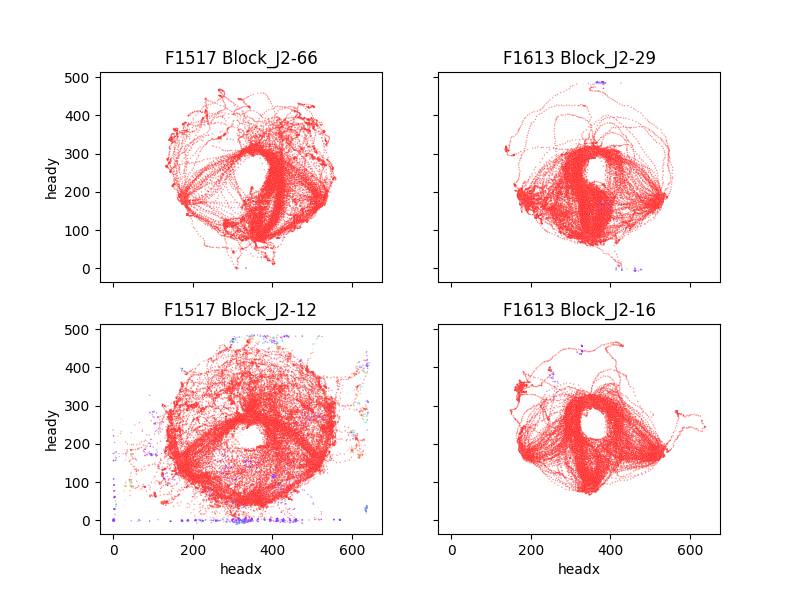

In [7]:
sessions_to_plot = 4

fig, axs = plt.subplots(2, int(sessions_to_plot/2), sharex=True, sharey=True, **{'figsize':(8,6)})
axs = np.ravel(axs)

for idx, session in frame_counts.iloc[:sessions_to_plot].iterrows():


    session_df = filter_for_session(df, session['fnum'], session['block'])

    sns.scatterplot(
        data = session_df,
        x='headx', 
        y="heady", 
        hue="headlikelihood", 
        palette = 'rainbow',
        s = 1,
        ax = axs[idx],
        legend = False,
        alpha = 0.5)

    axs[idx].invert_yaxis()
    axs[idx].set_title(f"F{session['fnum']} Block_{session['block']}")

plt.show()

How do the likelihood distributions vary across different landmarks in the session session?

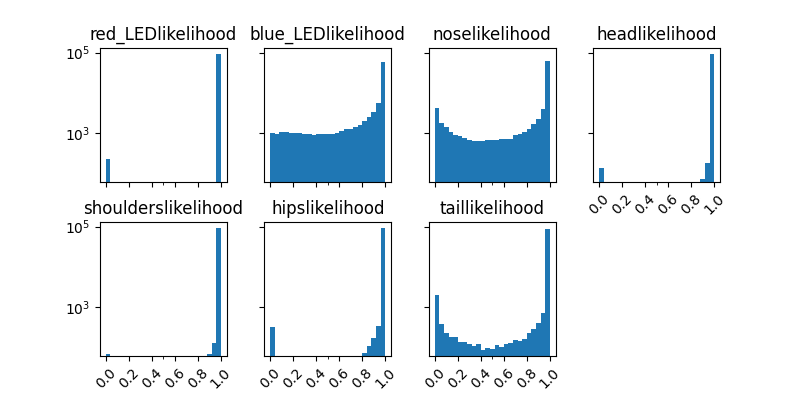

In [8]:
session_df = filter_for_session(df, 1517, 'J2-19')

columns = [c for c in df.columns if "likelihood" in c]

axs = session_df[columns].hist(
    bins=25, 
    sharex=True, 
    xrot = 45,
    sharey=True, 
    figsize=(8,4), 
    layout=(2, np.ceil(n_landmarks / 2).astype(int)),
    grid=False
    )

for ax in np.ravel(axs):
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yscale('log')

ax.set_ylabel('Frames (N)')
plt.show()


## 3. Head direction

We can use the vector between head and nose to look at the distribution of head directions. Doing so results in three distinct modes within the head-angle distribution that are consistent with the three response spout design, with the central spout being presumably a similar angle to the 12 o'clock response spout. 

In [9]:
def filter_for_head_and_nose(df, threshold:float=0.6):
    idx = df[(df['headlikelihood'] > threshold) & (df['noselikelihood'] > threshold)].index
    return df.loc[idx, ['headx','heady','headlikelihood','nosex','nosey','noselikelihood']]


def get_head2nose_vec(df):
    df['head_to_nose_x'] = df['nosex'] - df['headx']
    df['head_to_nose_y'] = df['nosey'] - df['heady']

    df = df.assign(head_to_nose_t = lambda x: np.arctan2(x.head_to_nose_y, x.head_to_nose_x))

    return df

In [10]:
hn_data = filter_for_head_and_nose(session_df, threshold=0.85)
hn_data = get_head2nose_vec(hn_data)

hn_data.head()

,headx,heady,headlikelihood,nosex,nosey,noselikelihood,head_to_nose_x,head_to_nose_y,head_to_nose_t
312372,340.068176,52.247395,1.000000,334.771942,45.819023,0.887595,-5.296234,-6.428371,-2.259932
312377,339.745758,56.483429,1.000000,331.488892,51.762203,0.898020,-8.256866,-4.721226,-2.622171
312378,340.231689,57.457939,0.999999,331.545776,52.640839,0.909689,-8.685913,-4.817101,-2.635234
312380,340.650299,55.695679,1.000000,333.455933,49.670147,0.954046,-7.194366,-6.025532,-2.444380
312385,339.816986,56.038136,1.000000,332.615417,51.287247,0.895019,-7.201569,-4.750889,-2.558427


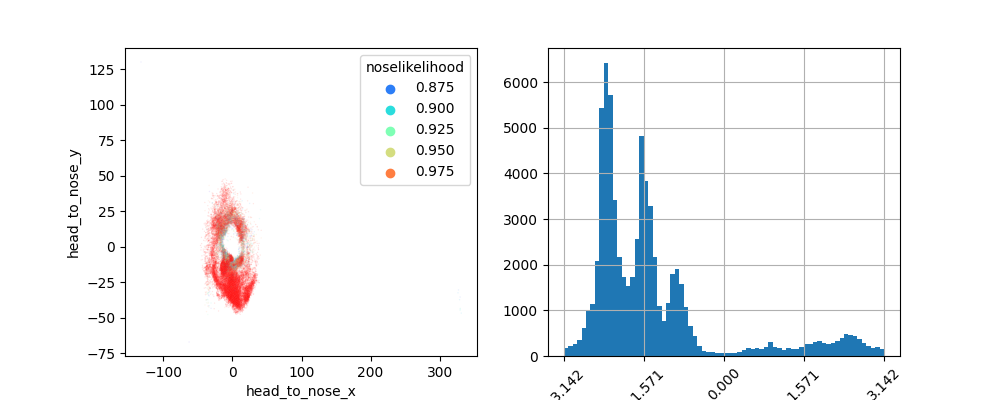

In [11]:
fig, axs = plt.subplots(ncols=2, **{'figsize':(10,4)})

# Scatter plot of all data
sns.scatterplot(
    data = hn_data,
    x='head_to_nose_x', 
    y='head_to_nose_y', 
    hue='noselikelihood', 
    palette='rainbow',
    alpha=0.1, 
    ax = axs[0],
    s=1)

# Histogram of angles
hn_data['head_to_nose_t'].hist(bins=72, ax=axs[1], xrot=45)

axs[1].set_xticks(np.linspace(-np.pi, np.pi, 5))

# plt.axis('square')
plt.show()

In general these results show that head direction data from deeplabcut is useful; however the non-uniform distribution of head directions that is a consequence of the task design may complicate any analysis of head direction tuning.

In [ ]:
hn_data['head_to_nose_t'].max()